In [1]:
import matplotlib.pyplot as plt
import tools.dataTools as dt
from constants import Constants
import figure_params
from tqdm.auto import tqdm
import os
import pickle
from textwrap import wrap

import pyaldata as pyal
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
from constants import Constants

figure_params.set_rc_params()
figure_params.setup_directories()

SUBFIG_DIR = Constants.FIG_FOLDER + 'fig4/'
if not os.path.exists(SUBFIG_DIR):
    os.makedirs(SUBFIG_DIR)

import subprocess
subprocess.call(['sh', '../simulation/fig_simulations/fig4_sims.sh'])

In [2]:
seeds = Constants.SEEDS
repertoires = Constants.UNIS
pca_dims = Constants.PCA_DIMS
moveset = dt.get_moveset(repertoires[0])
abr_dict = Constants.REPERTOIRE_ABR_DICTS[moveset]
seed_ex = 1000003


#### Calculate deviation angle

In [3]:
#params
redo = False
perturbation = 'rotation'
pert_set = 'v1'
pert_param = 10.0

for sim_set in ['uni_rad', 'uni_onehot']:
    fname = Constants.PROCESSED_DATA_FOLDER + sim_set + '/deviation_angle.pickle'
    if redo or (not os.path.isfile(fname)):
        rows_list = []
        for seed in tqdm(seeds):
            for j, repertoire in enumerate(repertoires[1:]):
                
                #activity during skill learning
                skill_df = dt.get_pyaldata(sim_set, seed, repertoire, 
                                epoch_fun = Constants.prep_exec_epoch, subtract_mean = False)
                model = pyal.fit_dim_reduce_model(skill_df, PCA(Constants.PCA_DIMS), 'MCx_rates')
                skill_df = pyal.apply_dim_reduce_model(skill_df, model, 'MCx_rates', 'both_pca')
                skill_av_df = pyal.trial_average(skill_df, 'target_param')
                skill_av_df = skill_av_df.sort_values(by = 'target_param', ascending=False) #sort movements

                #activity during adaptation
                pert_df = dt.get_pyaldata(sim_set, seed, repertoire, perturbation, pert_param, pert_set,
                                epoch_fun = Constants.prep_exec_epoch, subtract_mean = False)
                pert_df = pyal.apply_dim_reduce_model(pert_df, model, 'MCx_rates', 'both_pca')
                pert_av_df = pyal.trial_average(pert_df, 'target_param')
                pert_av_df = pert_av_df.sort_values(by = 'target_param', ascending=False)

                #get latent activity for first two reaches and reach after adaptation
                skill_pca_reach1 = np.array(skill_av_df.both_pca.values.tolist())[0]
                skill_pca_reach2 = np.array(skill_av_df.both_pca.values.tolist())[1]
                pert_pca_reach1 = np.array(pert_av_df.both_pca.values.tolist())[0]

                #get adjacent movement vector (between adjacent reaches)
                reach_diff = skill_pca_reach2 - skill_pca_reach1
                reach_diff = np.array([x/np.linalg.norm(x) for x in reach_diff])

                #get adaptation vector (between reaches before and after adaptation)
                pert_diff = pert_pca_reach1 - skill_pca_reach1
                pert_diff = np.array([x/np.linalg.norm(x) for x in pert_diff])
                # ave_pert_diff = np.mean(pert_diff, axis = 0)

                #get deviation angle: calc for each tstep
                angle = np.degrees(np.arccos(np.clip([np.dot(x, y) for x,y in zip(reach_diff,pert_diff)], -1.0,1.0)))

                temp = {
                    'seed': seed,
                    'sim_set': sim_set,
                    'repertoire': repertoire,
                    'perturbation': perturbation,
                    'pert_param': pert_param,
                    'pert_set': pert_set,
                    'adj_movement_vector': reach_diff,
                    'adaptation_vector': pert_diff,
                    'angle': angle,
                }
                rows_list.append(temp)

        angles_df = pd.DataFrame(rows_list)

        # plt.tight_layout()
        with open(fname, 'wb') as f:
            pickle.dump(angles_df, f)

with open(Constants.PROCESSED_DATA_FOLDER + 'uni_rad/deviation_angle.pickle', 'rb') as f:
    angles_df_rad = pickle.load(f)
with open(Constants.PROCESSED_DATA_FOLDER + 'uni_onehot/deviation_angle.pickle', 'rb') as f:
    angles_df_onehot = pickle.load(f)


#### Plot latents with deviation angle

In [4]:
def plot_deviation_angle(sim_set, seed, repertoire, perturbation, pert_param, pert_set, epoch_fun, rel_start, elev = 0, azim = 0, datafile = None):
    fig = plt.figure(figsize = (4,3))

    #activity during skill learning
    skill_df = dt.get_pyaldata(sim_set, seed, repertoire, 
                    epoch_fun = epoch_fun, subtract_mean = False, datafile = datafile)
    model = pyal.fit_dim_reduce_model(skill_df, PCA(Constants.PCA_DIMS), 'MCx_rates')
    skill_df = pyal.apply_dim_reduce_model(skill_df, model, 'MCx_rates', 'both_pca')
    skill_av_df = pyal.trial_average(skill_df, 'target_param')
    skill_av_df = skill_av_df.sort_values(by = 'target_param', ascending=False) #sort movements

    #activity during adaptation
    pert_df = dt.get_pyaldata(sim_set, seed, repertoire, perturbation, pert_param, pert_set,
                    epoch_fun = epoch_fun, subtract_mean = False)
    pert_df = pyal.apply_dim_reduce_model(pert_df, model, 'MCx_rates', 'both_pca')
    pert_av_df = pyal.trial_average(pert_df, 'target_param')
    pert_av_df = pert_av_df.sort_values(by = 'target_param', ascending=False)

    #get latent activity for first two reaches and reach after adaptation
    skill_pca_reach1 = np.array(skill_av_df.both_pca.values.tolist())[0]
    skill_pca_reach2 = np.array(skill_av_df.both_pca.values.tolist())[1]
    pert_pca_reach1 = np.array(pert_av_df.both_pca.values.tolist())[0]

    skill_pca = skill_av_df.both_pca.values.tolist()
    normalization_dist = np.median(np.linalg.norm(np.diff(skill_pca, axis = 1)[:,:,:3],axis = 2)) #only based on first 3 PCs
    print(normalization_dist, 20*normalization_dist)

    # PLOTTING
    ax = fig.add_subplot(projection = '3d')
    #plot before adaptation
    ax = dt.plot_3d(skill_av_df, 'both_pca', [1,2,3], rel_start, ax = ax, elev = elev, azim = azim)
    #plot after adaptation
    ax = dt.plot_3d(pert_av_df, 'both_pca', [1,2,3], rel_start, ax = ax, linestyle = '--', elev = elev, azim = azim)

    tstep = int(skill_pca_reach1.shape[0]/2) #plot vectors at middle of trajectories
    #adj movement vector
    ax.plot([skill_pca_reach1[tstep,0], skill_pca_reach2[tstep,0]], 
        [skill_pca_reach1[tstep,1], skill_pca_reach2[tstep,1]],
        [skill_pca_reach1[tstep,2], skill_pca_reach2[tstep,2]], color = 'r', linewidth = 2)
    #adaptation vector
    ax.plot([skill_pca_reach1[tstep,0], pert_pca_reach1[tstep,0]], 
        [skill_pca_reach1[tstep,1], pert_pca_reach1[tstep,1]],
        [skill_pca_reach1[tstep,2], pert_pca_reach1[tstep,2]], color = 'r', linestyle = '--',linewidth = 2)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    
    #plot scalebar
    length = 20*normalization_dist/np.sqrt(3)
    offset = length*0.2
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    zmin, zmax = ax.get_zlim()

    if elev > 0:
        z0 = zmin + (zmax-zmin)*0.1  
        z1 = z0 + length
    else:
        z0 = zmax - (zmax-zmin)*0.1
        z1 = z0 - length

    if (elev*azim <0):
        y0 = ymin + (ymax-ymin)*0.1
        y1 = y0 + length
    else:
        y0 = ymax - (ymax-ymin)*0.1
        y1 = y0 - length

    if azim > 0:
        x0 = xmax - (xmax-xmin)*0.1
        x1 = x0 - length
        y0 = ymax - (xmax-xmin)*0.8
        y1 = y0 - length
    else:
        x0 = xmin + (xmax-xmin)*0.8
        x1 = x0 + length

    # y0 = y + (ymax-ymin)*0.03
    # y1 = y - (ymax-ymin)*0.03
    # y = ymin if (elev*azim <0) else ymax
    # z = zmin if elev > 0 else zmax

    ax.plot([x0, x1], [y0, y1], [z0,z1], color = 'k', linewidth = 1.5) #scale bar
    ax.plot([x0 + offset, x0 - offset], [y0 , y0], [z0,z0], color = 'k', linewidth = 1.5) #scale bar
    ax.plot([x1 + offset, x1 - offset], [y1 , y1], [z1,z1], color = 'k', linewidth = 1.5) #scale bar

    # ax.plot([x0, x1], [y, y], [z,z], color = 'k', linewidth = 1.5) #scale bar
    # ax.plot([x0, x0], [y0, y1], [z,z], color = 'k', linewidth = 1.5) #side brackets
    # ax.plot([x1, x1], [y0, y1], [z,z], color = 'k', linewidth = 1.5)
    
    params = '_'.join([sim_set, str(seed), repertoire, perturbation, str(pert_param), pert_set, str(rel_start)])
    plt.tight_layout()
    plt.savefig(SUBFIG_DIR +'dev_angle_3d'+params+'.pdf', format = 'pdf')

    return ax



#### Latent dynamics for angular input network

In [5]:
%matplotlib widget 
perturbation = 'rotation'
pert_set = 'v1'
pert_param = 10.0

# angular inputs: preparation
ax = plot_deviation_angle('uni_rad', seed_ex, repertoires[-1], 
    perturbation, pert_param, pert_set, 
    Constants.prep_epoch, int(Constants.WINDOW_prep[0]/Constants.BIN_SIZE), 
    azim = -158, elev = 50)

# angular inputs: exec
ax = plot_deviation_angle('uni_rad', seed_ex, repertoires[-1], 
    perturbation, pert_param, pert_set, 
    Constants.exec_epoch, int(Constants.WINDOW_exec[0]/Constants.BIN_SIZE), 
    azim = -68, elev = 58)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

0.11657943 2.331588566303253


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

0.21237397 4.247479438781738


#### Latent dynamics for categorical input network

In [6]:
%matplotlib widget 
perturbation = 'rotation'
pert_set = 'v1'
pert_param = 10.0

# onehot inputs: preparation
ax = plot_deviation_angle('uni_onehot', seed_ex, repertoires[-1], 
    perturbation, pert_param, pert_set, 
    Constants.prep_epoch, int(Constants.WINDOW_prep[0]/Constants.BIN_SIZE),
    azim = 101, elev = -145)

#onehot inputs: exec
ax = plot_deviation_angle('uni_onehot', seed_ex, repertoires[-1], 
    perturbation, pert_param, pert_set, 
    Constants.exec_epoch, int(Constants.WINDOW_exec[0]/Constants.BIN_SIZE),
    azim = -120, elev = -127)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

0.0064464 0.12892800383269787


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

0.18300056 3.6600112915039062


#### Distances in neural space

In [12]:
%matplotlib inline

def graph_distances(sim_set, seed, repertoire, epoch_fun, ax = None):
    if ax is None:
        plt.figure(figsize=(3,3))
        ax = plt.gca()

    #get data
    init_df = dt.get_pyaldata(sim_set, seed, repertoire, epoch_fun=epoch_fun, subtract_mean = False)
    init_df = pyal.dim_reduce(init_df, PCA(Constants.PCA_DIMS), 'MCx_rates', 'both_pca')
    av_df = pyal.trial_average(init_df, 'target_param')
    data = av_df.both_pca.values.tolist()
    n_reaches = len(data)

    #calculate distances between timesteps (for normalization)
    dist_tsteps = np.linalg.norm(np.diff(data, axis = 1),axis = 2)
    dist_m = np.zeros((n_reaches, n_reaches))

    #calculate distances between reaches
    for i in range(n_reaches):
        for j in range(i, n_reaches):
            a = data[i]
            b = data[j]
            dist_m[j][i] = np.median(np.diagonal(scipy.spatial.distance.cdist(a,b,'euclidean')))/np.median(dist_tsteps)

    dist_m[dist_m == 0] = np.nan

    #plotting
    g = sns.heatmap(dist_m,square=True, cmap = 'YlGnBu_r', 
        vmin = 10, vmax = 40,
        xticklabels=range(1,n_reaches+1), yticklabels=range(1,n_reaches+1), ax = ax)
    return g


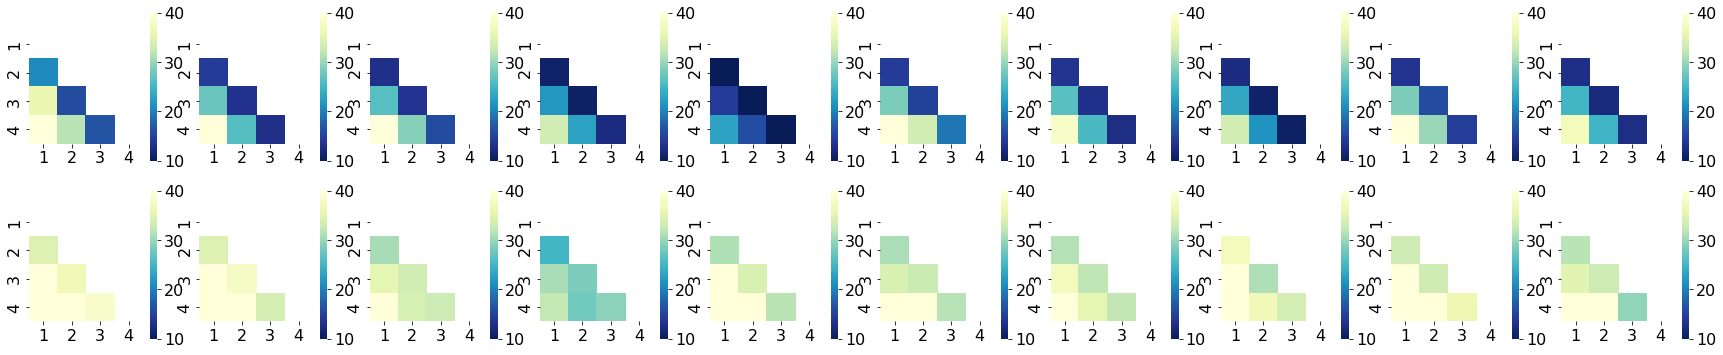

In [13]:
fig, axs = plt.subplots(nrows = 2, ncols = len(seeds), figsize = (30, 6))
for n, seed in enumerate(seeds):
    for m, sim_set in enumerate(['uni_rad', 'uni_onehot']):
        graph_distances(sim_set, seed, 'uni_4movs_10_50', epoch_fun=Constants.prep_exec_epoch, ax = axs[m][n])


In [14]:
# fig, axs = plt.subplots(nrows = 2, ncols = len(seeds), figsize = (30, 6))
# for n, seed in enumerate(seeds):
#     for m, sim_set in enumerate(['uni_rad', 'uni_onehot']):
#         graph_distances(sim_set, seed, 'uni_4movs_10_50', epoch_fun=Constants.prep_epoch, ax = axs[m][n])


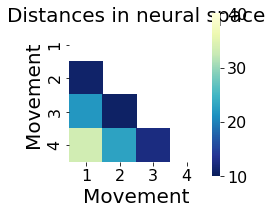

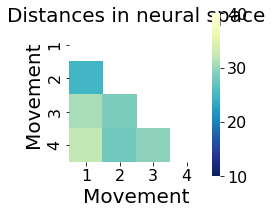

In [15]:
%matplotlib inline
repertoire = 'uni_4movs_10_50'

for m, sim_set in enumerate(['uni_rad', 'uni_onehot']):
    g = graph_distances(sim_set, seed_ex, repertoire, epoch_fun=Constants.prep_exec_epoch)
    g.set_xlabel('Movement')
    g.set_ylabel('Movement')
    g.set_title('Distances in neural space')
    params = '_'.join([sim_set, str(seed_ex), repertoire])
    plt.savefig(SUBFIG_DIR + 'distances_' + params+'.pdf', format='pdf', bbox_inches='tight' )


#### Motor output

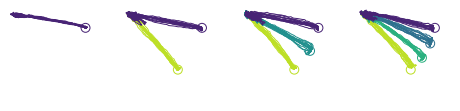

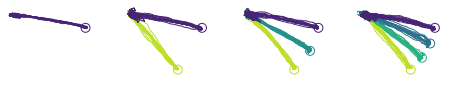

In [22]:
axs, params = dt.graph_outputs_all(seed_ex, 'uni_rad', repertoires)
plt.savefig(SUBFIG_DIR + "output_" + params +'.pdf', format='pdf')

axs, params = dt.graph_outputs_all(seed_ex, 'uni_onehot', repertoires)
plt.savefig(SUBFIG_DIR + "output_" + params +'.pdf', format='pdf')


#### Loss during adaptation

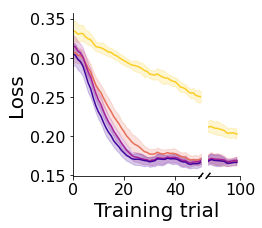

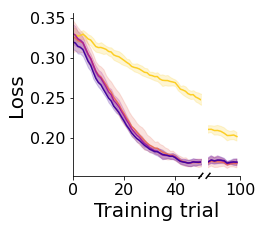

In [23]:
_, _, params = dt.graph_loss_broken_axis(seeds, 'uni_rad', repertoires, 'rotation', 10.0, 'v1', smooth=True, rel_loss = False)
plt.savefig(SUBFIG_DIR + "loss_"+params+".pdf", format='pdf', bbox_inches='tight' )

_, _, params = dt.graph_loss_broken_axis(seeds, 'uni_onehot', repertoires, 'rotation', 10.0, 'v1', smooth=True, rel_loss = False)
plt.savefig(SUBFIG_DIR + "loss_"+params+".pdf", format='pdf', bbox_inches='tight' )


In [24]:
def compare_simsets(data, reps, y):
    plt.figure(figsize = (3,3))

    for i, sim_set in enumerate(['uni_rad', 'uni_onehot']):
        df = data[(data.sim_set == sim_set)]
        
        colors = Constants.REPERTOIRE_COLORS[1:]             
        g = sns.swarmplot(x="repertoire", y=y, data=df, palette = colors, alpha = 0.4, 
            marker = 'o' if i == 0 else '^')

        g= dt.pointplot_across_repertoires(df, reps, y, 
            'grey' if i == 0 else 'lightgrey', ['solid'] if i == 0 else ['dashed'], ax = g)

        #stats 
        for i, rep1 in enumerate(reps):
            for j, rep2 in enumerate(reps[i+1:]):
                a = df[(df.repertoire == rep1)]
                b = df[(df.repertoire == rep2)]
                a_measure = a[y].values
                b_measure = b[y].values

                print(scipy.stats.shapiro(a_measure))
                _, pnorm = scipy.stats.ttest_rel(a_measure, b_measure)
                print(y, '\t', abr_dict[rep1], '\t', abr_dict[rep2], '\t', pnorm)
        print('\n') 

    # set ordering
    plt.setp(g.lines[:2], zorder=0)
    plt.setp(g.lines[4:6], zorder=0)
    plt.setp(g.collections[3], alpha=.5)
    plt.setp(g.lines[5:], alpha=.5)
    return g
    

### Compare measures between networks with angular or categorical inputs

In [25]:
def compare_simsets(data, reps, y):
    plt.figure(figsize = (3,3))

    for i, sim_set in enumerate(['uni_rad', 'uni_onehot']):
        df = data[(data.sim_set == sim_set)]
        
        colors = Constants.REPERTOIRE_COLORS[1:]             
        g = sns.swarmplot(x="repertoire", y=y, data=df, palette = colors, alpha = 0.4, 
            marker = 'o' if i == 0 else '^')


        g= dt.pointplot_across_repertoires(df, reps, y, 
            'grey' if i == 0 else 'lightgrey', ['solid'] if i == 0 else ['dashed'], ax = g)

        #stats 
        for i, rep1 in enumerate(reps):
            for j, rep2 in enumerate(reps[i+1:]):
                a = df[(df.repertoire == rep1)]
                b = df[(df.repertoire == rep2)]
                a_measure = a[y].values
                b_measure = b[y].values

                print(scipy.stats.shapiro(a_measure))
                _, pnorm = scipy.stats.ttest_rel(a_measure, b_measure)
                print(y, '\t', abr_dict[rep1], '\t', abr_dict[rep2], '\t', pnorm)
        print('\n') 

    # set ordering
    plt.setp(g.lines[:2], zorder=0)
    plt.setp(g.lines[4:6], zorder=0)
    plt.setp(g.collections[3], alpha=.5)
    plt.setp(g.lines[5:], alpha=.5)
    return g
    

#### Decay constant

In [26]:
#exponential function
def exp_func(t, A, K, C):
    return A * np.exp(K * t) + C

smooth = True
learn_set = None
perturbation = 'rotation'
pert_param = 10.0
pert_set = 'v1'

reps = Constants.UNIS[1:]

rows_list = []
colormap = dt.get_colormap(reps, 'plasma_r')
for sim_set in ['uni_rad', 'uni_onehot']:
    for seed in seeds:
        for repertoire in reps:

            # decay constant
            try:
                loss = dt.get_loss(seed, sim_set, repertoire, perturbation, pert_param, pert_set, smooth = smooth)
            except:
                print('failed', seed, sim_set, repertoire)
                continue
            t = np.arange(1,len(loss)+1)
            ## exponential fit
            p0 = (0.1,-0.1,0.2) # starting search koefs
            opt, pcov =  scipy.optimize.curve_fit(exp_func, t, loss, p0)
            A, K, C = opt
            fit_y = exp_func(t, A, K, C)

            # relative weight change
            outdir = dt.get_outdir(seed, sim_set, repertoire, perturbation, pert_param, pert_set)
            init_weights = dt.get_model_weights(outdir,before_training=True)['rec']
            dws = dt.get_weight_changes(outdir)['rec']
            rel_dw = dt.rel_dw(dws, init_weights)
            rel_dw_med_abs = np.median(np.abs(rel_dw))

            temp = {
                'seed': seed,
                'sim_set': sim_set,
                'repertoire': repertoire,
                'perturbation': perturbation,
                'pert_param': pert_param,
                'pert_set': pert_set,
                'decay': K,
                'rel_dw_med_abs': rel_dw_med_abs
            }
            rows_list.append(temp)

df = pd.DataFrame(rows_list)


ShapiroResult(statistic=0.93433678150177, pvalue=0.49187615513801575)
decay 	 2 Mov. 	 3 Mov. 	 6.340290434926504e-05
ShapiroResult(statistic=0.93433678150177, pvalue=0.49187615513801575)
decay 	 2 Mov. 	 4 Mov. 	 4.713458558209372e-07
ShapiroResult(statistic=0.9132314920425415, pvalue=0.3039339482784271)
decay 	 3 Mov. 	 4 Mov. 	 0.014990632341495023


ShapiroResult(statistic=0.8802066445350647, pvalue=0.13120867311954498)
decay 	 2 Mov. 	 3 Mov. 	 0.057158444630524656
ShapiroResult(statistic=0.8802066445350647, pvalue=0.13120867311954498)
decay 	 2 Mov. 	 4 Mov. 	 0.08395112004868822
ShapiroResult(statistic=0.8549806475639343, pvalue=0.06656379997730255)
decay 	 3 Mov. 	 4 Mov. 	 0.4291294290710239




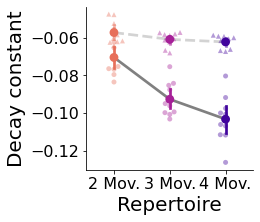

In [27]:
%matplotlib inline
#plot decay rate (mean)
g = compare_simsets(df, repertoires[1:], 'decay')
g.set_ylabel('Decay constant')
params = '_'.join(filter(None, [perturbation, pert_set, str(pert_param) if pert_param else None]))
plt.savefig(SUBFIG_DIR + "decay_constant.pdf", format='pdf', bbox_inches='tight' )
#normal


#### Relative weight change

ShapiroResult(statistic=0.9412643313407898, pvalue=0.5671657919883728)
rel_dw_med_abs 	 2 Mov. 	 3 Mov. 	 1.1012787702549715e-05
ShapiroResult(statistic=0.9412643313407898, pvalue=0.5671657919883728)
rel_dw_med_abs 	 2 Mov. 	 4 Mov. 	 3.3430297404023296e-07
ShapiroResult(statistic=0.9470590353012085, pvalue=0.6338549852371216)
rel_dw_med_abs 	 3 Mov. 	 4 Mov. 	 0.1514115633635608


ShapiroResult(statistic=0.9367422461509705, pvalue=0.5173650979995728)
rel_dw_med_abs 	 2 Mov. 	 3 Mov. 	 0.3046231095303023
ShapiroResult(statistic=0.9367422461509705, pvalue=0.5173650979995728)
rel_dw_med_abs 	 2 Mov. 	 4 Mov. 	 0.4734918199648731
ShapiroResult(statistic=0.9402556419372559, pvalue=0.55586177110672)
rel_dw_med_abs 	 3 Mov. 	 4 Mov. 	 0.577653418106663




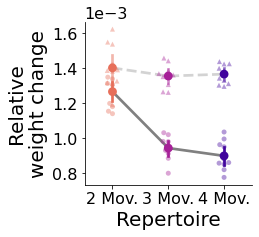

In [28]:
#plot relative weight change (mean of median)
g = compare_simsets(df, repertoires[1:], 'rel_dw_med_abs')
g.set_ylabel("\n".join(wrap('Relative weight change',14)))
params = '_'.join(filter(None, [perturbation, pert_set, str(pert_param) if pert_param else None]))
plt.savefig(SUBFIG_DIR + "rel_weight_change.pdf", format='pdf', bbox_inches='tight' )
#normal


#### Deviation angle

ShapiroResult(statistic=0.8278104662895203, pvalue=0.03148845210671425)
dev_angle 	 2 Mov. 	 3 Mov. 	 0.003276468198687232
ShapiroResult(statistic=0.8278104662895203, pvalue=0.03148845210671425)
dev_angle 	 2 Mov. 	 4 Mov. 	 0.0007407866740398602
ShapiroResult(statistic=0.9765958189964294, pvalue=0.9443862438201904)
dev_angle 	 3 Mov. 	 4 Mov. 	 0.08602475280744491


ShapiroResult(statistic=0.9729480147361755, pvalue=0.9167512059211731)
dev_angle 	 2 Mov. 	 3 Mov. 	 0.2391967101343025
ShapiroResult(statistic=0.9729480147361755, pvalue=0.9167512059211731)
dev_angle 	 2 Mov. 	 4 Mov. 	 0.0002939762138370461
ShapiroResult(statistic=0.9231386780738831, pvalue=0.3838784396648407)
dev_angle 	 3 Mov. 	 4 Mov. 	 0.015383830192709074




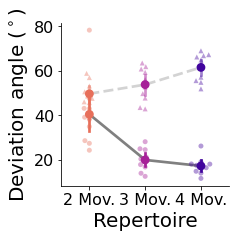

In [29]:
#plot deviation angle (mean of medians)
with open(Constants.PROCESSED_DATA_FOLDER + 'uni_rad/deviation_angle.pickle', 'rb') as f:
    angles_df_rad = pickle.load(f)
with open(Constants.PROCESSED_DATA_FOLDER + 'uni_onehot/deviation_angle.pickle', 'rb') as f:
    angles_df_onehot = pickle.load(f)
angles_df = pd.concat([angles_df_rad, angles_df_onehot])
angles_df['dev_angle'] = angles_df.apply(lambda row:np.median(row.angle), axis = 1)

g = compare_simsets(angles_df, repertoires[1:], 'dev_angle')
g.set_ylabel('Deviation angle ($^\circ$)')
params = '_'.join(filter(None, [perturbation, pert_set, str(pert_param) if pert_param else None]))
plt.savefig(SUBFIG_DIR + "deviation_angle.pdf", format='pdf', bbox_inches='tight' )